<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2022 - Homework 01</h1>

<h2 style="color:blue"> Núria Camí, Ana de Garay and Claudia Herron Mulet</h2>

<h3 style="color:blue">2022-04-26</h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member)

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not drear being too verbose or too elementary.

### External sources

Getting inspiration from any book, document, blog, wep page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,**
understand every such material, and explain it in you own words, even more exhaustively.

Dare not **copy/paste literally.** I do detect it, believe me, even with a missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Tuesday, April 19. They are to be uploaded to the Virtual Campus.

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2022-03-28 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In this notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

In `Exponential.02.Earthquake` we use known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan, disregarding analytical conjugate prior formulas, and then comparing your results to the analytical ones. Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

<h2 style="color:blue">Solution:</h2>

First, we **load rstan** (the R interface to use Stan language) and set the recommended options.

In [1]:
require(rstan)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



[1] 4

Now we can start doing the required simulations with its corresponding analysis.

<h2 style="color:blue">1. Prior pdf for $\lambda$.</h2>

We know from the statement that $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$, where $\alpha > 0$ and $\beta > 0$ are unknown shape and scale parameters, respectively. Following the guidelines in ```S7.3.03.Exponential.02.Earthquake```, we see that $\alpha=1$ and $\beta=30$. This is due as a consecuence of setting the effective sample size to 1 and applying the formula for the expectation of a gamma distribution, given that E($\lambda$) is 1/30.

The Stan code simply draws samples from a gamma distribution, and we specify the parameters at runtime.

In [2]:
# Stan model to generate samples of a gamma distribution
Gamma_String <- "
    //functions {}
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    transformed data {}
    parameters{}
    transformed parameters {}
    model{ }
    generated quantities{
        real y=gamma_rng(alpha,beta);
        }
"

# Translate the model to C++ and compile to DSO (Dynamic Shared Object)
Gamma_stanDso <- stan_model( model_code=Gamma_String ) 

Once that we have the DSO, we have to input the selected distribution parameters and Stan configuration to perform the simulation. Let's first take a look to the meaning of each parameter:
* **chains**	: A positive integer specifying the number of Markov chains. The default is 4.
* **algorithm**	: One of sampling algorithms that are implemented in Stan. No parameters in this scenario so we use "Fixed_param".
* **seed**	: The seed for random number generation.
* **iter**: A positive integer specifying the number of iterations for each chain (including warmup)
* **warmup**: A positive integer specifying the number of warmup (aka burnin) iterations per chain.
* **thin**: A positive integer specifying the period for saving samples. The default is 1, which is usually the recommended value.

In [3]:
# Specify data
prior.a<-1
prior.b<-30
Gamma_dataList <- list("alpha" = prior.a, "beta" = prior.b)

# Generate prior sample
GammaPrior_stanFit <- sampling( object=Gamma_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 4, seed = 24056, iter = 10000, warmup = 0, thin = 1)

Finally,  we extract the prior sample and plot its histogram together with the theoretical gamma distribution.

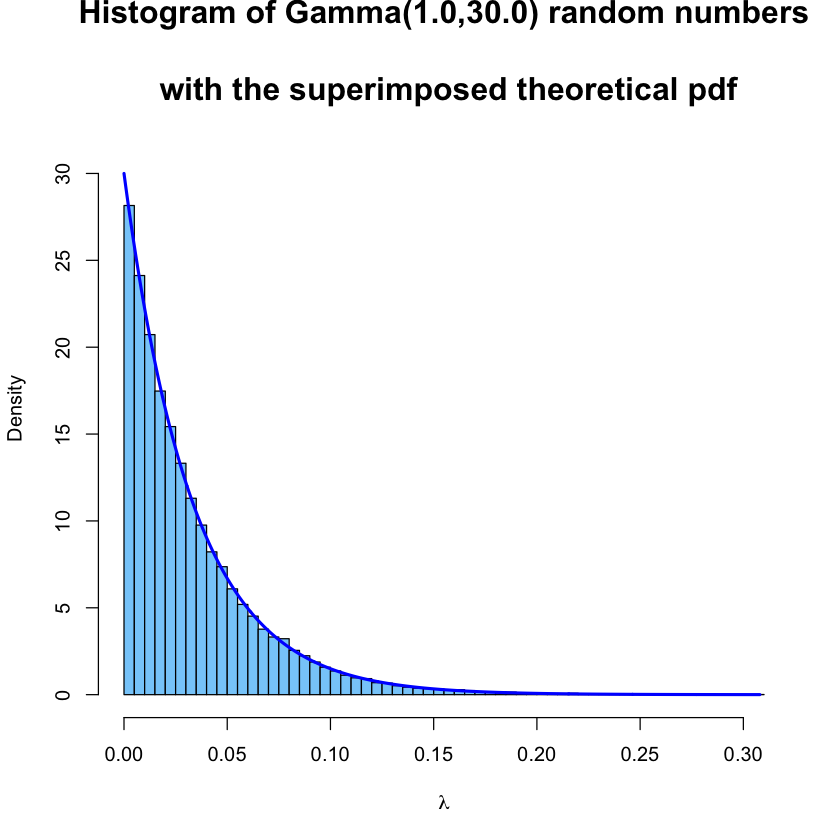

In [4]:
# Extract sample from the prior
y<-extract(GammaPrior_stanFit,par="y")$y
y.max<-max(y)
u<-seq(0,y.max,length=1000)

# Define the theoretical gamma distribution 
df.theor<-dgamma(u,shape=prior.a,rate=prior.b)
f.max<-max(df.theor)

# Histogram
hist(y,freq=FALSE,col="LightSkyBlue",ylim=c(0,f.max*1.1),xlab=expression(lambda),
     main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",prior.a,prior.b),nclass=60,cex.main=1.6)
lines(u,df.theor,lwd=2.5,col="blue")

<h2 style="color:blue">2. Prior predictive pdf for the waiting time.</h2> 

The random variable that measures the waiting time (in days) between the 𝑖-th earthquake and the following one follows an Exponential distribution. That is:

$$
    Y_{i}\mskip8mu\text{i.i.d.}\sim\mskip8mu\operatorname{Exponential}(\lambda),
$$

where $\lambda$ is the conjugate prior described in the previous section. We also know that the expected waiting time between earthquakes will be $\operatorname{E}(Y)=1/\lambda$ days. 

Note that we can assume $Y_i$ as an independent and identically distributed random variable alluding at the premises taken at the beginning of the notebook ```S7.3.03.Exponential.02.Earthquake```.

The following cell shows the Stan model for the prior predictive pdf described here.

In [5]:
# Stan model to generate samples of an exponential distribution
model_PriorPred <-"
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    parameters {
        real lambda;   // parameter is an unbounded real (mean of observed xbar)
    }
    model {
        lambda ~ gamma(alpha,beta);   // prior
    }
    generated quantities {
        real y;
        y = exponential_rng(lambda);   // prior prediction
    }
"

# Translate the model to C++ and compile to DSO
model_PriorPred_stanDso <- stan_model( model_code=model_PriorPred ) 

Once that we specify the model, we proceed with the simulation.

In [6]:
# Specify data
prior.a<-1
prior.b<-30
pppdf_dataList <- list("alpha" = prior.a, "beta" = prior.b)

# Generate prior sample
model_PriorPred_stanFit <- sampling( object=model_PriorPred_stanDso, 
                         data = pppdf_dataList,
                         chains = 1, 
                         seed = 24025, 
                         iter = 10000, 
                         warmup = 600, 
                         thin = 1)


SAMPLING FOR MODEL 'cea2a46b0b002c9539028e00f2e78098' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration:  601 / 10000 [  6%]  (Sampling)
Chain 1: Iteration: 1600 / 10000 [ 16%]  (Sampling)
Chain 1: Iteration: 2600 / 10000 [ 26%]  (Sampling)
Chain 1: Iteration: 3600 / 10000 [ 36%]  (Sampling)
Chain 1: Iteration: 4600 / 10000 [ 46%]  (Sampling)
Chain 1: Iteration: 5600 / 10000 [ 56%]  (Sampling)
Chain 1: Iteration: 6600 / 10000 [ 66%]  (Sampling)
Chain 1: Iteration: 7600 / 10000 [ 76%]  (Sampling)
Chain 1: Iteration: 8600 / 10000 [ 86%]  (Sampling)
Chain 1: Iteration: 9600 / 10000 [ 96%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.01403 seconds (Warm-up)
Chain 1:                0.3784

Warning message:
“There were 4714 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [7]:
# Extract sample from the prior predictive
y<-extract(model_PriorPred_stanFit,par="y")$y

# Quantiles
q.y<-quantile(y,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.y,2)

# Maximum
ymax<-max(q.y)
round(ymax,2)

# Truncate in order to be able to plot the histogram
y.trunc<-y[y<ymax]  

5%    10%    20%    30%    40%    50%    60%    70%    80%    90% 
  1.57   3.34   7.39  12.86  20.24  30.11  44.50  68.78 116.91 282.79

[1] 282.79

Finally, we define the theoretical destribution and we plot it together with our sample of the prior predictive pdf.

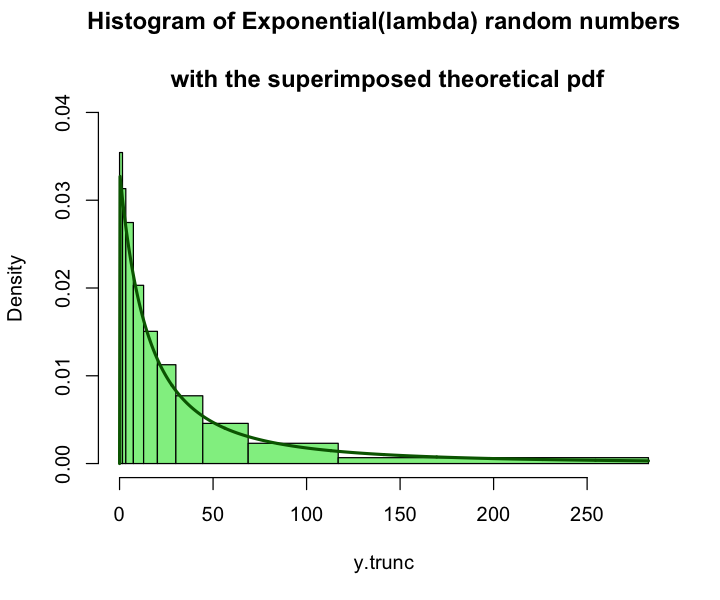

In [8]:
# Define the theoretical distribution 
options(repr.plot.width=6,repr.plot.height=5)
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}
ymax<-max(q.y)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=prior.a,b=prior.b)

# Histogram
hist(y.trunc,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Exponential(lambda) random numbers
    \n with the superimposed theoretical pdf"), breaks=c(min(y.trunc),q.y,max(y.trunc)),ylim=c(0,0.040))
lines(u,yu,lwd=2.5,col="DarkGreen")

We observe that the distribution is exponential, as expected.

<h2 style="color:blue">3. Posterior pdf for $\lambda$.</h2> 

Once taking $n$ independent exponential observations of the experiment performed with the prior pdf described in section 2, then are able to define the posterior pdf for $\lambda$. At the end, the posterior distribution of $\lambda$ will be also a Gamma but with parameters $\alpha$ and $\beta$ updated. If we consider as $y=(y_{1},\dots,y_{n})$ the $n$ observations performed with average $\overline{y}$, then:

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\
    \beta'&=&\beta+n\,\overline{y},
    \end{array}\right.
$$

are the parameters for the Gamma distribution of the posterior pdf for $\lambda$. This is the analytical posterior distribution.

In this exercise, we will perform the MCMC simulation to obtain the posterior.

Recall that in our example, we observed a total of 9 earthquake occurances. Thus, the number of time periods between earthquakes is $n=8$ and the data vector observed is $y=(16, 8, 114, 60, 4, 23, 30, 105)$, with $\overline{y}=45$. 

In [9]:
# Data vector y observed
y<-c(16, 8, 114, 60, 4, 23, 30, 105)
n<-length(y)

# Mean of y
ybar<-mean(y)
round(ybar,2)

[1] 45

Then we define our posterior model and specify our data.

In [10]:
modelString = "
  data{
    int<lower=0> n ;
    real y[n] ; 
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0> lambda ;
    }
  model{
    lambda ~ gamma(a,b) ;
    y ~ exponential(lambda) ; 
    }"
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 
    

In [11]:
# Specify data:
dataList = list(y=y,n=n,a=prior.a,b=prior.b)

In [12]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = dataList, 
                     chains = 3,
                     iter = 1000, 
                     warmup = 200, 
                     thin = 1)

Finally, we plot the MCMC posterior.

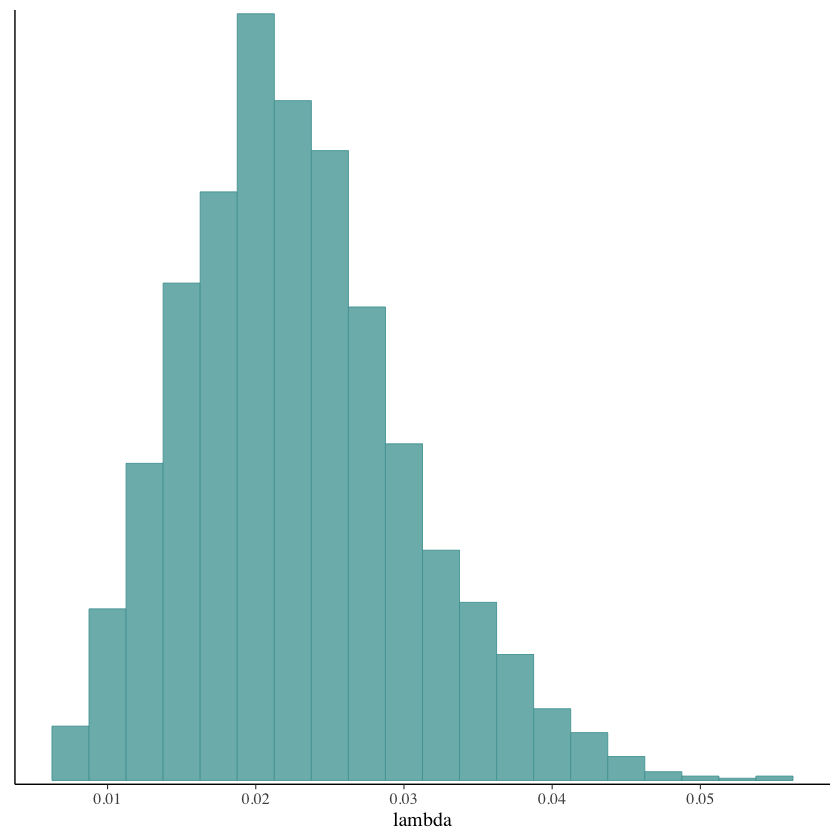

In [14]:
require("bayesplot")
color_scheme_set("teal")
options(repr.plot.width=7,repr.plot.height=7)


# Histogram
a = mcmc_hist(stanFit, pars = c("lambda"),binwidth=0.0025)
a

For the theoretical posterior, the updated parameters for the posterior pdf of $\lambda$ are:

In [15]:
# parameters of posterior pdf of lambda: alpha' and beta'
nybar<-sum(y)
post.a<-prior.a+n
post.b<-prior.b+nybar
post.a
post.b

[1] 9

[1] 390

In [16]:
# Measures of the posterior gamma distribution 

# mean 
Theor.lambda.post.mean<-post.a/post.b
round(Theor.lambda.post.mean,4)

# mode
Theor.lambda.post.mode<-(post.a-1)/post.b  # For alpha>1, 0 for alpha=1.
round(Theor.lambda.post.mode,4)

# variance
Theor.lambda.post.var<-post.a/post.b^2
round(Theor.lambda.post.var,6)

# std
Theor.lambda.post.sd<-sqrt(Theor.lambda.post.var)
round(Theor.lambda.post.sd,4)

[1] 0.0231

[1] 0.0205

[1] 5.9e-05

[1] 0.0077

Also, we can generate a sample from the distribution that we know that is the posterior.

In [17]:
# Specify data
Gamma_dataList <- list("alpha" = post.a, "beta" = post.b)

# Generate posterior sample
GammaPosterior_stanFit <- sampling( object=Gamma_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 4, seed = 24056, iter = 10000, warmup = 0, thin = 1)

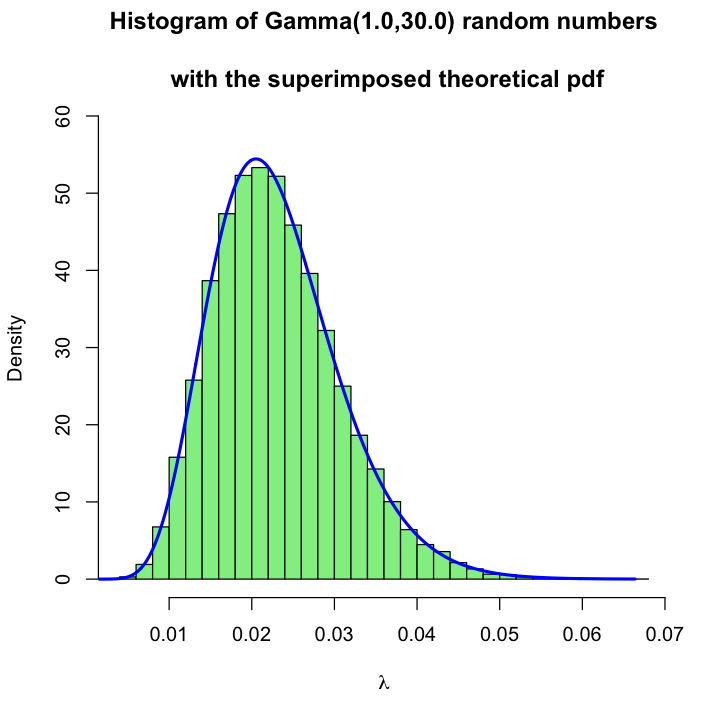

In [18]:
# Extract sample from the posterior
y<-extract(GammaPosterior_stanFit,par="y")$y
y.max<-max(y)
u<-seq(0,y.max,length=1000)

# Define the theoretical gamma distribution 
options(repr.plot.width=6,repr.plot.height=6)
v<-seq(0,max(y),length=1000)
yv<-dgamma(v,shape=post.a,rate=post.b)
max.yv<-max(yv)

# Histogram
hist(y,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",prior.a,prior.b), xlab=expression(lambda),ylim=c(0,max.yv*1.1),breaks=25)
lines(v,yv,lwd=2.5,col="blue")

Finally, in this plot we observe the theoretical posterior and the sample obtained from the posterior gamma discovered analytically. We observe that it conincides with the MCMC simulation. 

<h2 style="color:blue">4. Posterior predictive pdf for the waiting time.</h2> 

Finally, the posterior predictive pdf for the waiting time will behave like an Exp($\lambda$), where $\lambda$ is distributed as the posterior pdf described in the previous section.

In [19]:
# Stan model to generate samples of an exponential distribution
Exp_Stancode <-"
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    parameters {
        real lambda;   // parameter is an unbounded real (mean of observed xbar)
    }
    model {
        lambda ~ gamma(alpha,beta);   // prior
    }
    generated quantities {
        real y;
        y = exponential_rng(lambda);   // prior prediction
    }
"

# Translate the model to C++ and compile to DSO
Exp_stanDso <- stan_model( model_code=Exp_Stancode )

In [20]:
# Specify data:
pppdf_dataList <- list("alpha" = post.a, "beta" = post.b)

# Generate posterior sample
Exp_stanFit <- sampling( object=Exp_stanDso, 
                         data = pppdf_dataList,
                         chains = 1, 
                         seed = 24025, 
                         iter = 10000, 
                         warmup = 600, 
                         thin = 1)


SAMPLING FOR MODEL 'cea2a46b0b002c9539028e00f2e78098' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration:  601 / 10000 [  6%]  (Sampling)
Chain 1: Iteration: 1600 / 10000 [ 16%]  (Sampling)
Chain 1: Iteration: 2600 / 10000 [ 26%]  (Sampling)
Chain 1: Iteration: 3600 / 10000 [ 36%]  (Sampling)
Chain 1: Iteration: 4600 / 10000 [ 46%]  (Sampling)
Chain 1: Iteration: 5600 / 10000 [ 56%]  (Sampling)
Chain 1: Iteration: 6600 / 10000 [ 66%]  (Sampling)
Chain 1: Iteration: 7600 / 10000 [ 76%]  (Sampling)
Chain 1: Iteration: 8600 / 10000 [ 86%]  (Sampling)
Chain 1: Iteration: 9600 / 10000 [ 96%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.010192 seconds (Warm-up)
Chain 1:                0.138

Warning message:
“There were 42 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [21]:
# Extract sample from the prior
y<-extract(Exp_stanFit,par="y")$y

# Quantiles
q.y<-quantile(y,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.y,2)

# Maximum
ymax<-max(q.y)
round(ymax,2)

# Truncate in order to be able to plot the histogram
y.trunc<-y[y<ymax] 

5%    10%    20%    30%    40%    50%    60%    70%    80%    90% 
  2.11   4.47   9.67  15.36  22.71  31.40  42.09  56.46  76.23 114.55

[1] 114.55

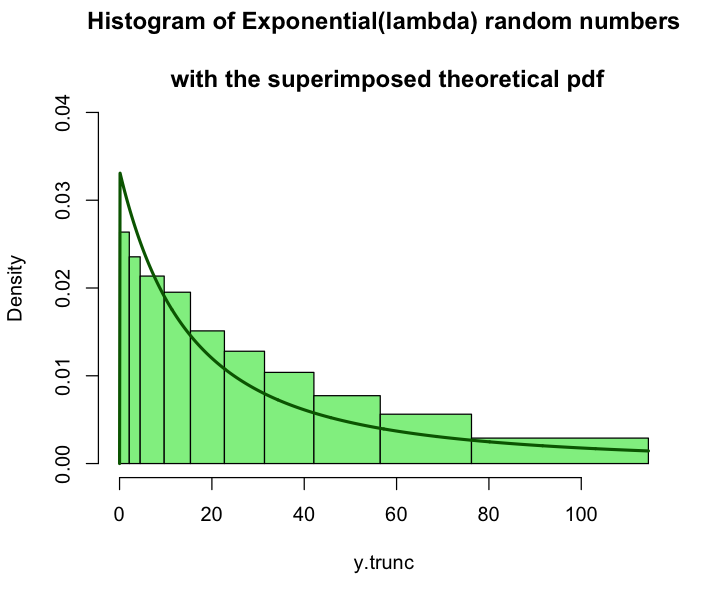

In [22]:
# Define the theoretical exponential distribution 
options(repr.plot.width=6,repr.plot.height=5)
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}
ymax<-max(q.y)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=prior.a,b=prior.b)

# Histogram
hist(y.trunc,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Exponential(lambda) random numbers
    \n with the superimposed theoretical pdf"), breaks=c(min(y.trunc),q.y,max(y.trunc)),ylim=c(0,0.040))
lines(u,yu,lwd=2.5,col="DarkGreen")

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
   0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [23]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan. There are several known workarounds; you can try to find one but do not despair if you fail to develop a workable version.

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.02.ipynb` 
is rather tricky: Stan does not allow integer parameters thus the JAGS code cannot be translated literally.

Diaconis and Ylvisaker (1985) compare both mixture conjugate priors with a $ \operatorname{Unif}(0,1)$ prior with the data above. 

Comparing the MAP estimators, they observe that in a first approximation, they coincide, but spreads do depend on the prior.

They repeat the computations above with a larger sample. 

In [24]:
n1<-50
x1.obs<-14

Their conclusion is that with small data, prior matters, but with larger samples, a finely tuned choice of prior is less important.

<h2 style="color:blue">Solution</h2> 

The number of heads that we get in $n$ tosses of a spinning coin (likelihood function) behaves like a Binomial distribution:

$$
    x\mskip8mu\sim\mskip8mu\operatorname{B}(n,\theta),
$$

where $\theta$ is given a conjugate prior consisting of a mixture of three Beta distributions:

$$
   \theta\mskip8mu\sim\mskip8mu0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Note that since the conjugate prior of $\theta$ is in itself a bimodal function, it exhibits two local maxima. Recap that Beta distribution has two positive parameters $\alpha$ and $\beta$ that appear as exponents of the random variable and control the shape of the distribution.

First, let's see how this three Beta distributions look separately.

In [25]:
# set parameters
prior.a1<-10
prior.b1<-20
prior.a2<-15
prior.b2<-15
prior.a3<-20
prior.b3<-10
prior.gamma1<-0.5
prior.gamma2<-0.2

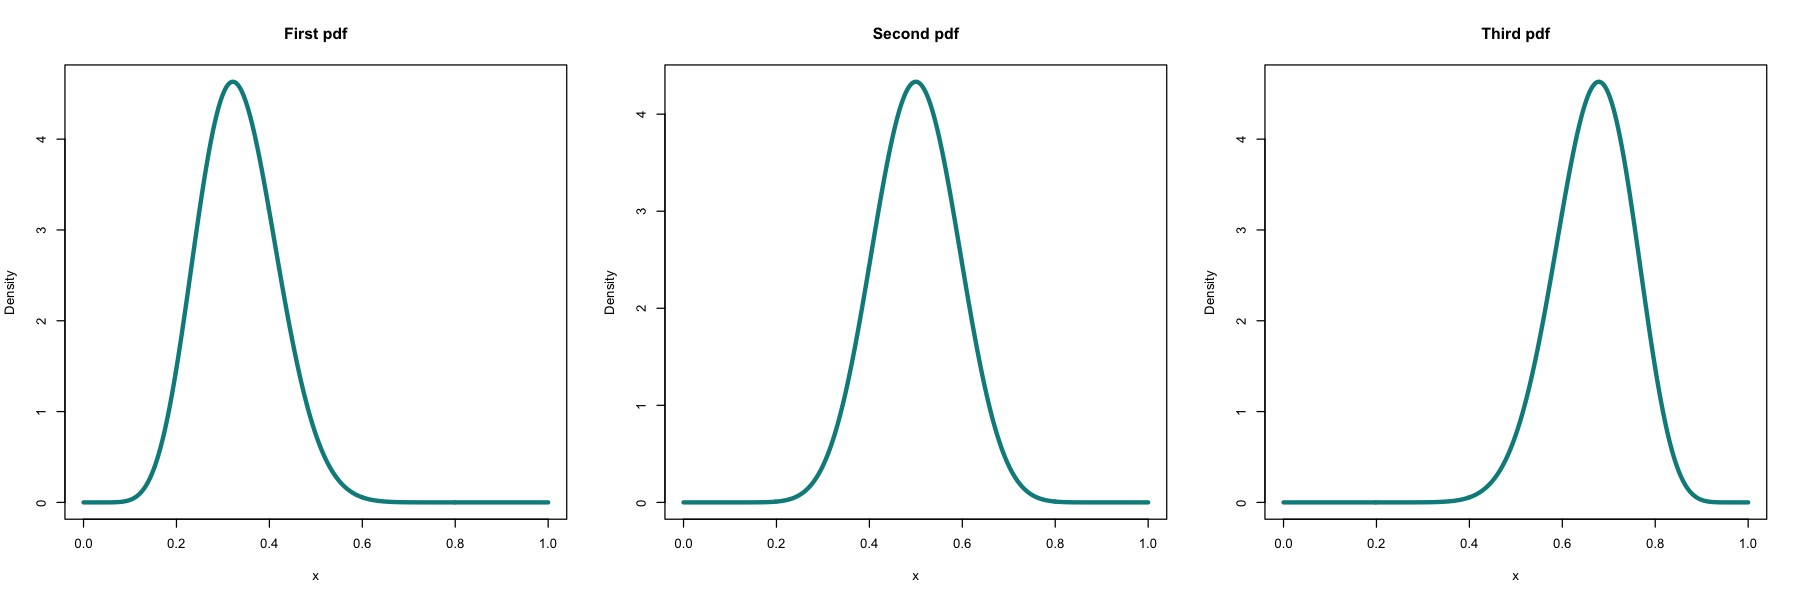

In [26]:
# do the three Beta distribution plots
options(repr.plot.width=15,repr.plot.height=5)
v<-seq(0,1,length=500)
old.par<-par(mfrow=c(1,3))
plot(v,dbeta(v,prior.a1,prior.b1),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="First pdf")
plot(v,dbeta(v,prior.a2,prior.b2),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Second pdf")
plot(v,dbeta(v,prior.a3,prior.b3),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Third pdf")
par(old.par)

And the mixture prior:

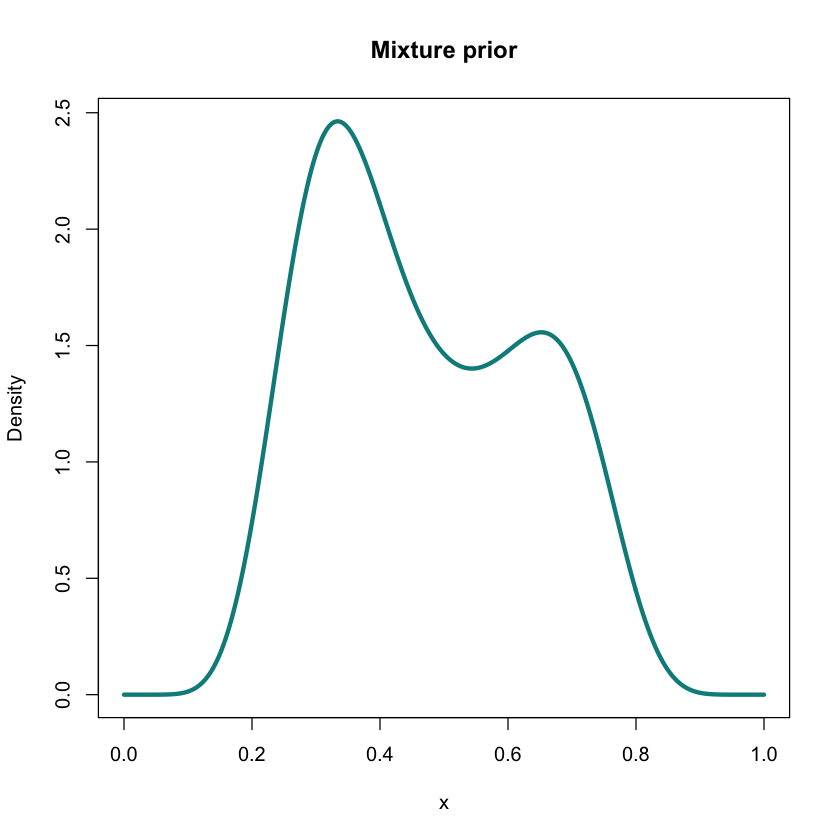

In [27]:
# mixture prior plot
mixture.prior.pdf<-function(theta){
    return(prior.gamma1*dbeta(theta,prior.a1,prior.b1)+prior.gamma2*dbeta(theta,prior.a2,prior.b2)+(1-(prior.gamma1 + prior.gamma2))*dbeta(theta,prior.a3,prior.b3))
    }

options(repr.plot.width=7,repr.plot.height=7)
v<-seq(0,1,length=500)
plot(v,mixture.prior.pdf(v),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Mixture prior")

<h2 style="color:blue">1. Using the theoretical formulas (prior predictive pdf, posterior pdf, posterior predictive pmf)</h2> 

We'll begin considering the same data as in the previous approach seen in class:

In [ ]:
# Number of trials
n<-10
# Observed x
x.obs<-3

The **prior pdf for $\theta$ $(h(\theta))$** is obtained as a mixture of three random variables following a Beta($\alpha, \beta$) distribution and its corresponding coefficients: 

$$
	h(\theta)=\gamma_1\cdot h_{1}(\theta)+ \gamma_2\cdot h_{2}(\theta)+(1-(\gamma_1 + \gamma_2))\cdot h_{3}(\theta),
$$

where $h_{1}(\theta)$, $h_{2}(\theta)$ and $h_{3}(\theta)$ are the pdf of this three r.v. and $(\gamma_1, \gamma_2, 1-(\gamma_1, \gamma_2))$ is the vector of coefficients with $\gamma_1, \gamma_2\in(0,1)$. In our example, the vector of coefficients is (0.50, 0.20, 0.30).

The **likelihood** (or conditional pdf), $f(x\,|\,\theta)$, follows a $\binomdist(n,\theta)$ distribution:

$$
        f(x\,|\,\theta)=\binom{n}{x}\, \theta^{x}\cdot(1-\theta)^{n-x},\mskip40mu x=0,1,\dots,n.
$$

By assuming that $h_{1}(\theta)$, $h_{2}(\theta)$ and $h_{3}(\theta)$ belong to the conjugate family of the likelihood, we can build the **joint pdf** $(f(x,\theta))$ as the product of the likelihood and the prior:

$$
        f(x,\theta)=f(x\mid \theta)\cdot h(\theta)=\gamma_1\cdot f_{1}(x,\theta)+ \gamma_2\cdot f_{2}(x,\theta)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x,\theta),
$$

where $f_{i}(x,\theta)=f(x\,|\,\theta)\cdot h_{i}(\theta)\,\,$ for $i=1,2,3$.

By definition, the **marginal pdf of $x$** $(f(x))$ is obtained by integrating the previous expression out $\theta$:

$$
        \int f(x,\theta) \,d\theta = \int f(x\mid \theta)\cdot h(\theta) \,d\theta = \int \gamma_1\cdot f_{1}(x,\theta)+ \gamma_2\cdot f_{2}(x,\theta)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x,\theta) \,d\theta,
$$

Then, we can express $f(x)$ as:

$$
	f(x)=\gamma_1\cdot f_{1}(x)+\gamma_2\cdot f_{2}(x)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x),
$$	

where: $f_{i}(x)={\displaystyle\int} f(x\,|\,\theta)\cdot h_{i}(\theta)\,d\theta\,\,$ for $i=1,2,3$.

Note that the above expression given by $f(x)$ means that the **prior predictive pdf for $x$** ($h(x)$), is a mixture of three partial prior predictive pdf's ($f_{1}$, $f_{2}$ and $f_{3}$) with the same coefficients ($\gamma_1, \gamma_2,$ and $1-(\gamma_1 + \gamma_2)$) as the **prior pdf for $\theta$** described at the beginning. Note also that $f_{1}$, $f_{2}$ and $f_{3}$ follow from the general formulas of the conjugate pair.

At this point, given the observed data $x$, we are able to deduce the **posterior pdf for $\theta$**, $h(\theta\,|\,x)$. By applying the _Bayes' rule_, we get:

$$
    h(\theta\,|\,x)=\dfrac{f(x\,|\,\theta)\cdot h(\theta)}{f(x)}
        =\dfrac{f(x,\theta)}{f(x)}
        =\dfrac{\gamma_1\cdot f_{1}(x,\theta)+ \gamma_2\cdot f_{2}(x,\theta)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x,\theta)}
            {\gamma_1\cdot f_{1}(x)+\gamma_2\cdot f_{2}(x)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x)}.
$$

Since we can write the named _partial posterior pdf's_ as $h_{i}(\theta\,|\,x)=\dfrac{f_{i}(x,\theta)}{f_{i}(x)}\,\,$ for $i=1,2,3$, the resultant expression for $h(\theta\,|\,x)$ can be reformulated as a mixture of _posterior mixture weights_ ($\widehat{\gamma}_1(x), \widehat{\gamma}_2(x),$ and $1 - (\widehat{\gamma}_1(x)+ \widehat{\gamma}_2(x))$):

$$
	h(\theta\,|\,x)=\widehat{\gamma}_1(x)\cdot h_{1}(\theta\,|\,x) +\widehat{\gamma}_2(x)\cdot h_{2}(\theta\,|\,x)
		+(1-(\widehat{\gamma}_1(x)+ \widehat{\gamma}_2(x)))\cdot h_{3}(\theta\,|\,x),
$$

where 

$$
	\widehat{\gamma}_i(x)=\dfrac{\gamma\cdot f_{i}(x)}{\gamma_1\cdot f_{1}(x)+\gamma_2\cdot f_{2}(x)+(1-(\gamma_1 + \gamma_2))\cdot f_{3}(x)} \mskip40mu i=1,2.
$$

The expressions of $h(\theta\,|\,x)$ and $h(\theta)$ may look similar due to its linear structure. However, the main difference is that $h(\theta\,|\,x)$ depends on the observed data $x$ and $h(\theta)$ does not. Hence, the coefficients (or weights) and the corresponding partial functions that form both expressions are obviously not the same. 

 <h2 style="color:blue">2. Using independent random numbers (rbeta() functions, etc.)</h2> 

R programming language allows us to generate random distributed numbers with a set of built-in functions, such as ``runif(), rnorm(), rbinom()``, etc. Therefore, thanks to them we can reformulate our $\theta$ parameter distribution by means of combining three ``rbeta(n, a, b)`` functions, where parameters $a$ and $b$ correspond to those giving shape to the distribution of each beta $\betadist(\alpha, \beta)$, and $n$ is just the number of beta random numbers to generate, i.e., the size of the sample.

We stablish the nº of experiments to perform:

In [29]:
N<-20000

Next we generate a sample array in order to indicate from which beta distribution must we take the samples, where the probability of first beta is $0.5$, the probability of second distribution is $0.2$ and finally $0.3$ for the third beta distribution, as stated above in the definition of the mixture of betas distribution:

In [30]:
beta_sampling <- sample(c(1,2,3), #vector with elements from which to choose (indexes of our beta distributions)
                        replace = TRUE, #sampling with replacement
                        size = N, #sample size
                        prob=c(0.5, 0.2, 0.3) #vector of probability weights for obtaining the elements of the vector being sampled
                        )

Now we can reproduce a sample $\theta$'s array by random sampling from our three beta distributions according to the previously defined vector:

In [31]:

theta <- c(rbeta(N, prior.a1, prior.b1)[beta_sampling == 1], 
           rbeta(N, prior.a2, prior.b2)[beta_sampling == 2], 
           rbeta(N, prior.a3, prior.b3)[beta_sampling == 3])

And therefore the histogram of our simulated prior will be:

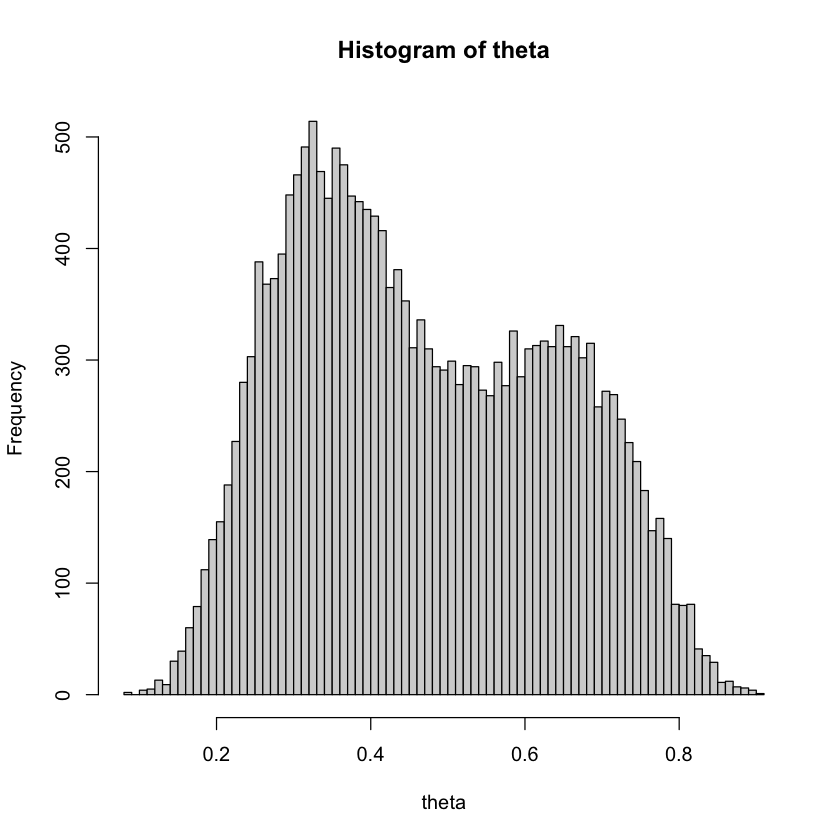

In [32]:
hist(theta, breaks=100)

That is in fact consistent with our previous mixture prior plot. 

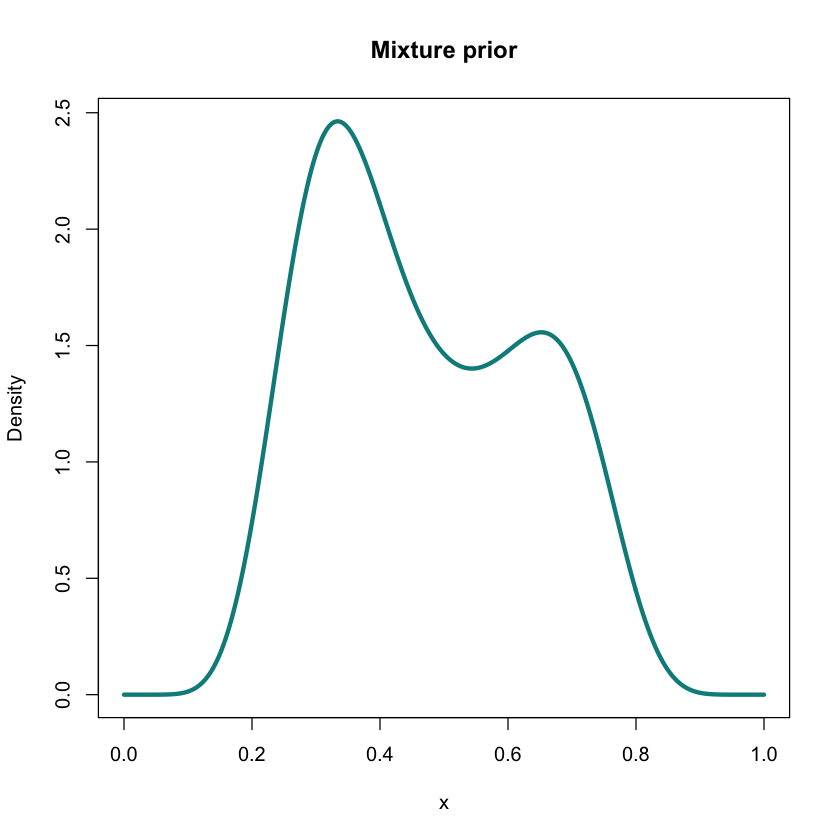

In [33]:
plot(v,mixture.prior.pdf(v),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Mixture prior")

Once we have our $\theta$ sample we are able to reproduce the binomial behaviour of the flipping coin by means of the rbinom(n, size, prob) function, whichs models the number of heads in N experiments (n parameter); the size parameter is the number of distinct attempts, and prob is the probability of success (i.e., of head) on each trial, which in our case comes given by the previously extracted theta sampling vector.

In [34]:
heads <- rbinom(n = N, size = n , prob = theta)

The relative frequencies obtained for each possible number of heads in our 10 trials are then

In [35]:
pmf <- table(heads)/sum(table(heads))
pmf

heads
      0       1       2       3       4       5       6       7       8       9 
0.01700 0.05790 0.11195 0.14315 0.15805 0.15055 0.13440 0.10985 0.07000 0.03640 
     10 
0.01075 

And therefore we can represent its prior predictive probability mass function as 

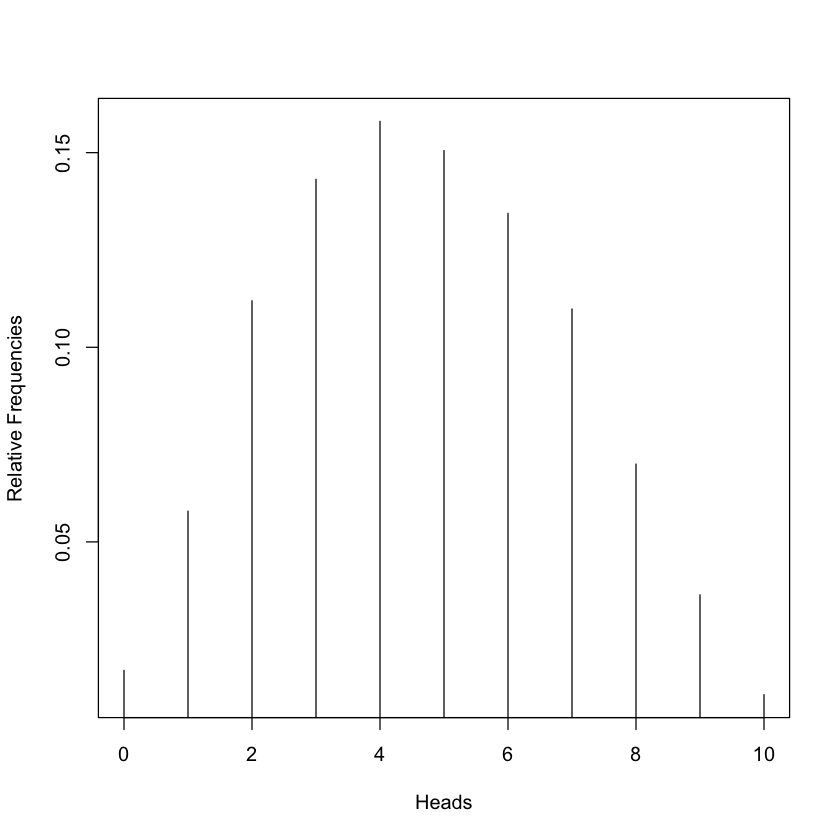

In [36]:
matplot(x=names(pmf),y=pmf, type ='h',
        xlab="Heads",ylab="Relative Frequencies")


So the probability of obtaining x=3 heads would be:

In [37]:
pmf[x.obs + 1]

3 
0.14315

Therefore we can seletect those thetas that produce x=3, i.e.,

In [38]:
t_3heads <- theta[heads == 3]

Whose histogram would be:

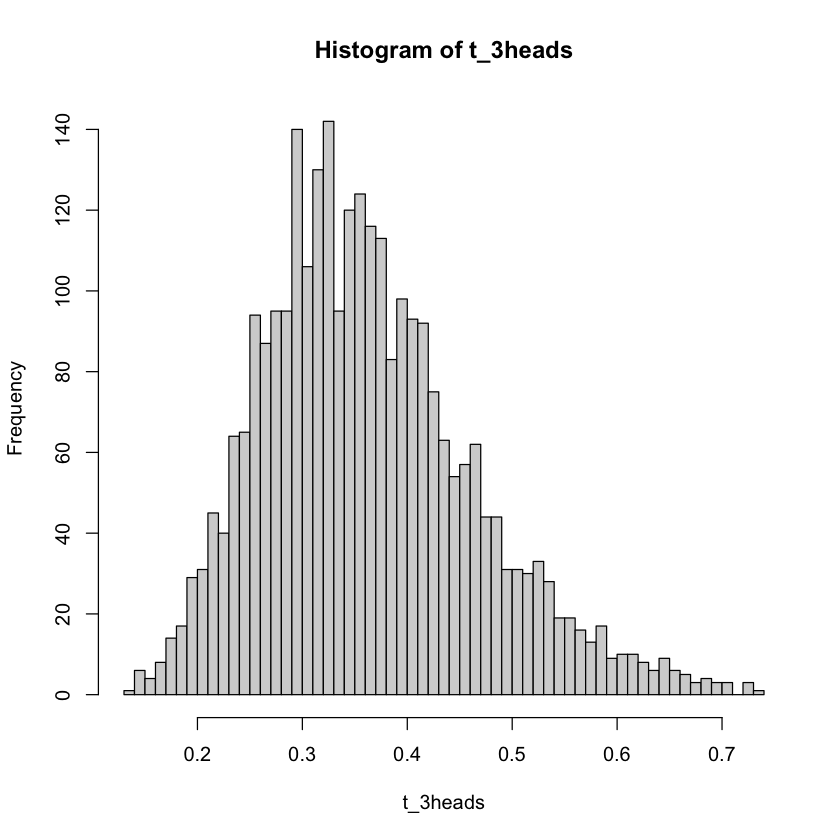

In [39]:
hist(t_3heads, breaks=50)

Now we can simulate the partial posteriors probability density function for each of the three beta distributions modeling the behaviour of the theta parameter, considering x=3:

In [40]:
posterior.a1<-prior.a1+x.obs
posterior.b1<-prior.b1+n-x.obs
posterior.a2<-prior.a2+x.obs
posterior.b2<-prior.b2+n-x.obs
posterior.a3<-prior.a3+x.obs
posterior.b3<-prior.b3+n-x.obs

In [41]:
sprintf("Posterior parameters for the first component: (%2.0d,%2.0d)",posterior.a1,posterior.b1)
sprintf("Posterior parameters for the second component: (%2.0d,%2.0d)",posterior.a2,posterior.b2)
sprintf("Posterior parameters for the third component: (%2.0d,%2.0d)",posterior.a3,posterior.b3)

[1] "Posterior parameters for the first component: (13,27)"

[1] "Posterior parameters for the second component: (18,22)"

[1] "Posterior parameters for the third component: (23,17)"

And following the same reasoning as above, we can obtain the simulated posterior for $\theta$:

In [42]:
theta.pos <- c(rbeta(N, posterior.a1, posterior.b1)[beta_sampling == 1], 
               rbeta(N, posterior.a2, posterior.b2)[beta_sampling == 2], 
               rbeta(N, posterior.a3, posterior.b3)[beta_sampling == 3])

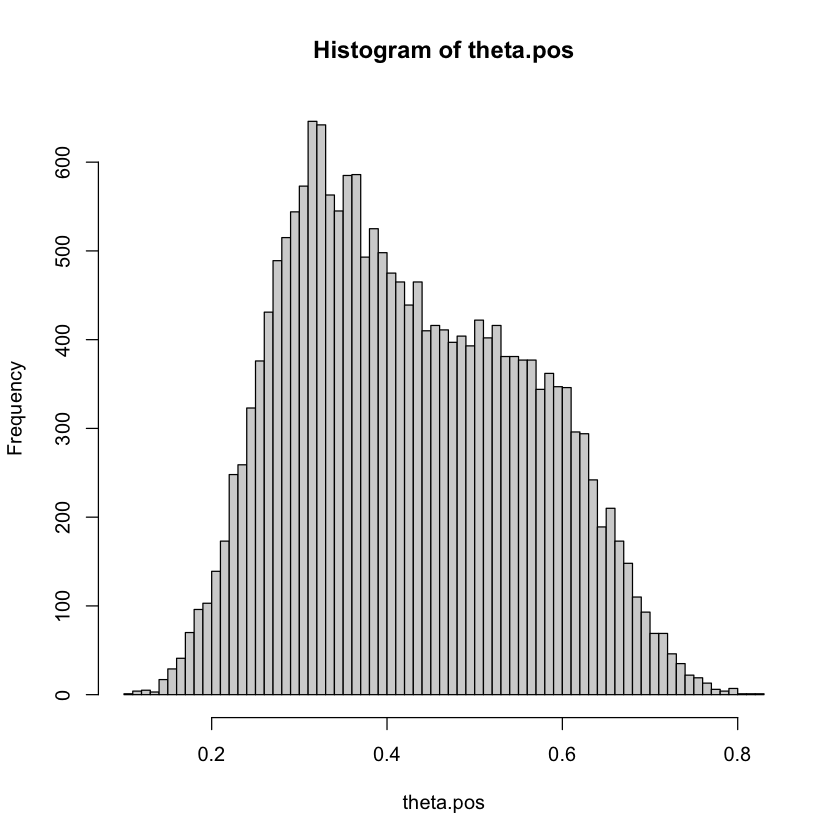

In [43]:
hist(theta.pos, breaks=100)

And therefore the simulated posterior of the experiment would be:

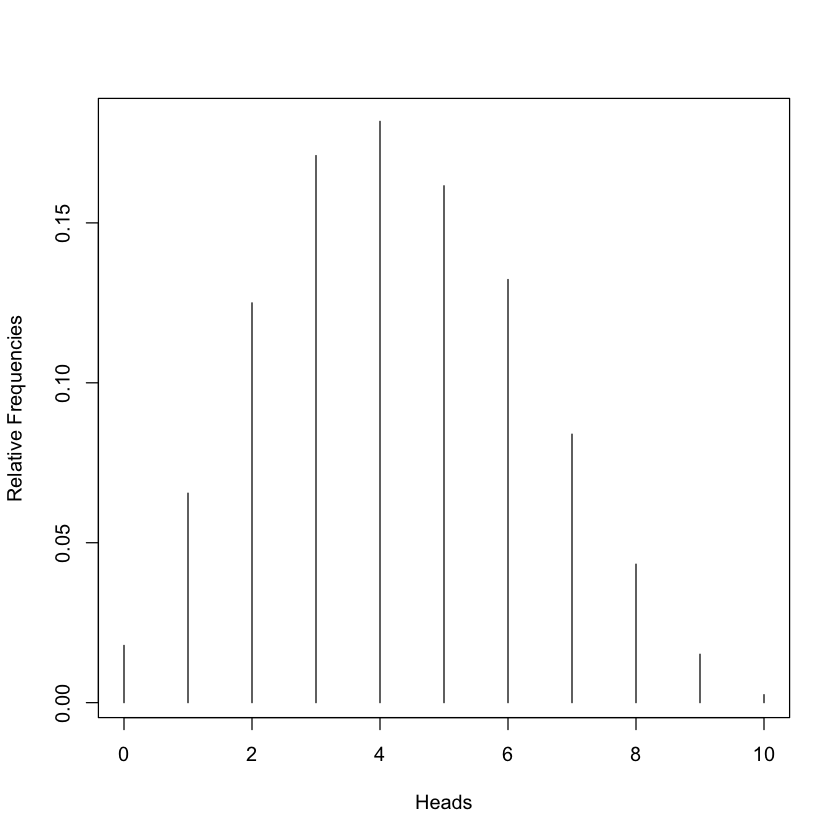

In [44]:
heads <- rbinom(n = N, size = n , prob = theta.pos)

pmf <- table(heads)/sum(table(heads))

matplot(x=names(pmf),y=pmf, type ='h',
        xlab="Heads",ylab="Relative Frequencies")


<h2 style="color:blue">3. JAGS version</h2> 

First we load the packages needed to interact with JAGS.

In [9]:
require(R2jags)

Secondly, we define the parameters that we'll use in our JAGS model, defined below. JAGS takes as input a Bayesian model description — prior plus likelihood — and data and returns an MCMC sample from the posterior distribution. (https://bookdown.org/kevin_davisross/bayesian-reasoning-and-methods/introduction-to-jags.html) The jags function takes data and starting values as input. It automatically writes a JAGS script, calls the model, and saves the simulations for easy access in R. (https://rdrr.io/cran/R2jags/man/jags.html)

In [10]:
# Parameters
prior.a1<-10
prior.b1<-20
prior.a2<-15
prior.b2<-15
prior.a3<-20
prior.b3<-10
prior.gamma1<-0.5
prior.gamma2<-0.2

# Number of trials
n<-10
# Observed x
x.obs<-3

# list
Mix.2.3.dat<-list(a1=prior.a1,b1=prior.b1,
                 a2=prior.a2,b2=prior.b2,
                 a3=prior.a3,b3=prior.b3,
                 gamma1=prior.gamma1,
                 gamma2=prior.gamma2,
                 n=n,x=x.obs)

Then, we are ready to build the JAGS model. We'll also store it in an external file ``Mix.2.3.jag``.

In [11]:
cat(
"model
    {
    x~dbin(p,n)             # Binomial likelihood
    
    p<-theta[r]             # Prior (mixture of three beta r.v defined below)

    r~dcat(g[])             # Categorical distribution of a 3-vector g[]

    theta[1]~dbeta(a1,b1)   # The three beta r.v
    theta[2]~dbeta(a2,b2)
    theta[3]~dbeta(a3,b3)

    g[1]<-gamma1            # Definition of g[] containing the mixed probabilities
    g[2]<-gamma2
    g[3]<-1-(gamma1 + gamma2)
    }"
    ,file="Mix.2.3.jag")    # Saving model

We next compile our JAGS model. The interface function ``jags()`` has several parameters. For example, the default value n.thin=50 it means we are keeping one term in 50 from each sequence and throwing out the other 49. We keep the default number of Markov chains to generate (3) https://cran.r-project.org/web/packages/R2jags/R2jags.pdf. 

In [12]:
Mix.2.3.m1<-jags(data=Mix.2.3.dat, n.chains=3,n.iter=5000,n.burnin=500, 
        parameters.to.save=c("theta","p"), model.file="Mix.2.3.jag")

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 4
   Total graph size: 19

Initializing model



Here we generate a summary of our simulated samples

In [13]:
print(Mix.2.3.m1)

Inference for Bugs model at "Mix.2.3.jag", fit using jags,
 3 chains, each with 5000 iterations (first 500 discarded), n.thin = 4
 n.sims = 3375 iterations saved
         mu.vect sd.vect  2.5%   25%   50%   75% 97.5%  Rhat n.eff
p          0.360   0.100 0.202 0.290 0.346 0.415 0.600 1.002  1400
theta[1]   0.326   0.074 0.193 0.274 0.324 0.375 0.481 1.002  1400
theta[2]   0.491   0.087 0.325 0.431 0.489 0.551 0.657 1.003   880
theta[3]   0.662   0.088 0.481 0.604 0.669 0.724 0.816 1.002  3000
deviance   3.220   0.988 2.643 2.686 2.843 3.291 6.321 1.001  2600

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 0.5 and DIC = 3.7
DIC is an estimate of expected predictive error (lower deviance is better).


We can do a Traceplot to assess stationarity of the chains (https://rdrr.io/cran/R2jags/man/traceplot.html, https://mc-stan.org/rstan/reference/stanfit-method-traceplot.html). It displays a plot of iterations vs. sampled values for each variable in the chain, with a separate plot per variable.

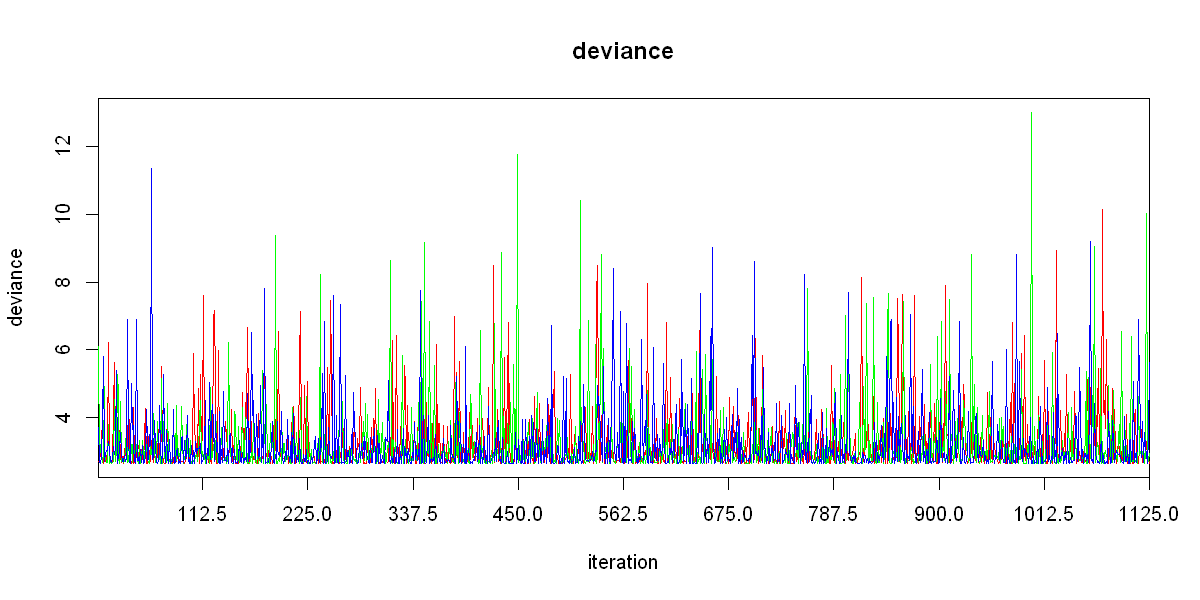

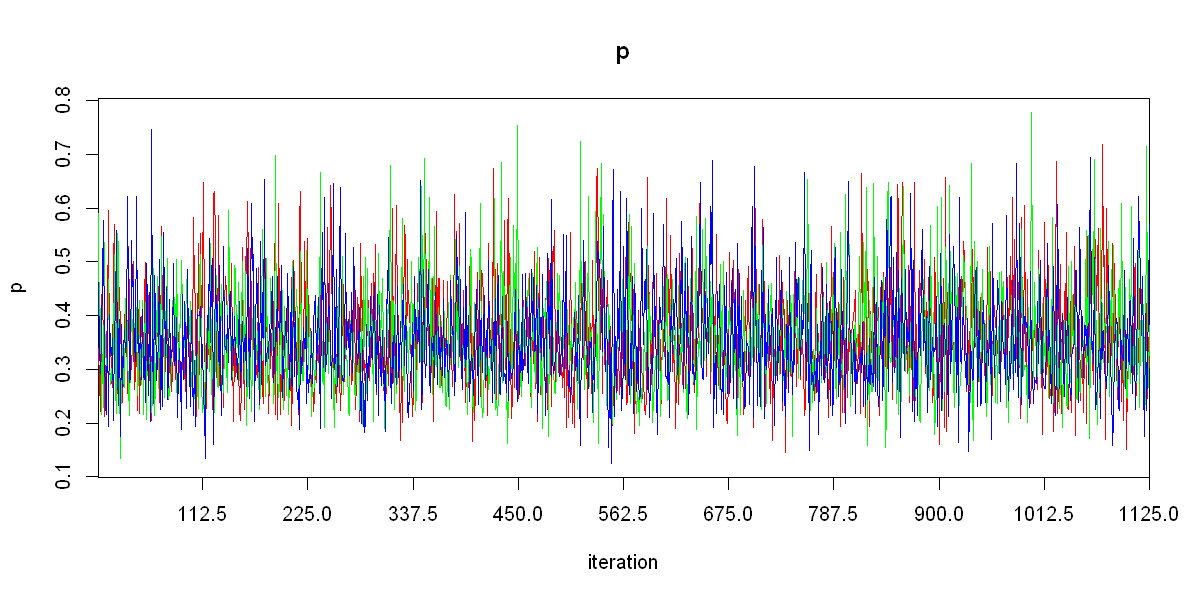

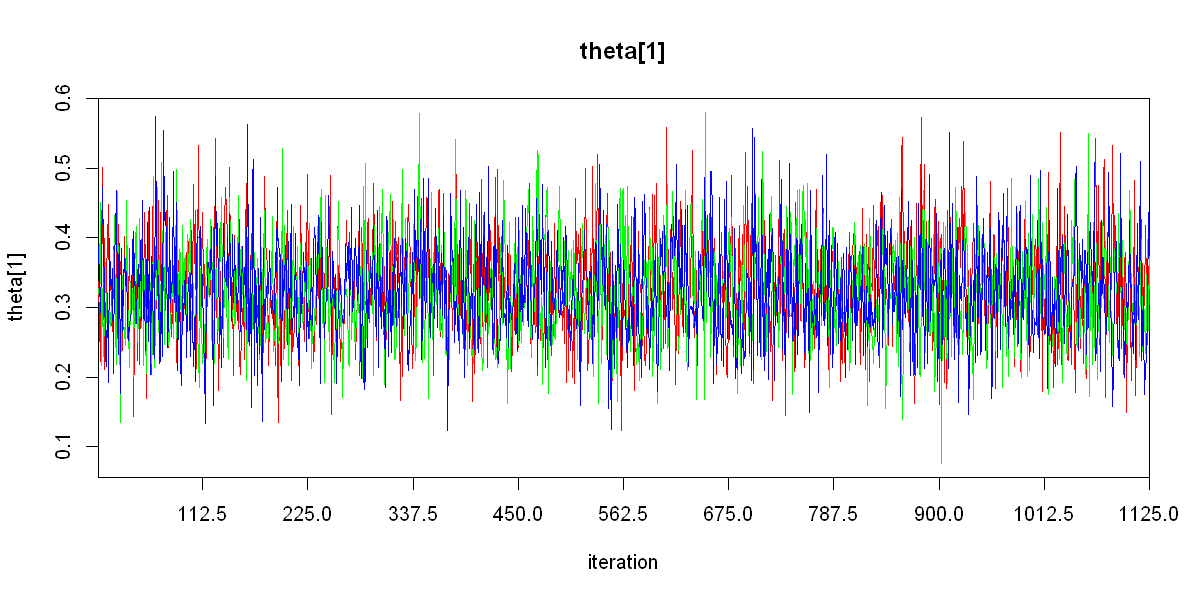

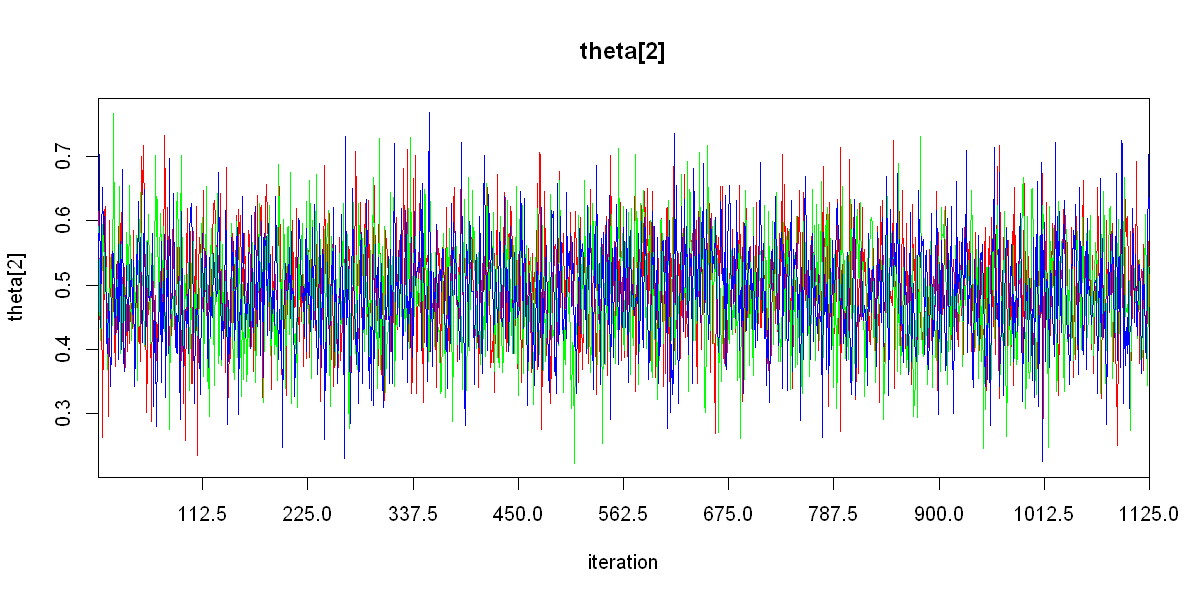

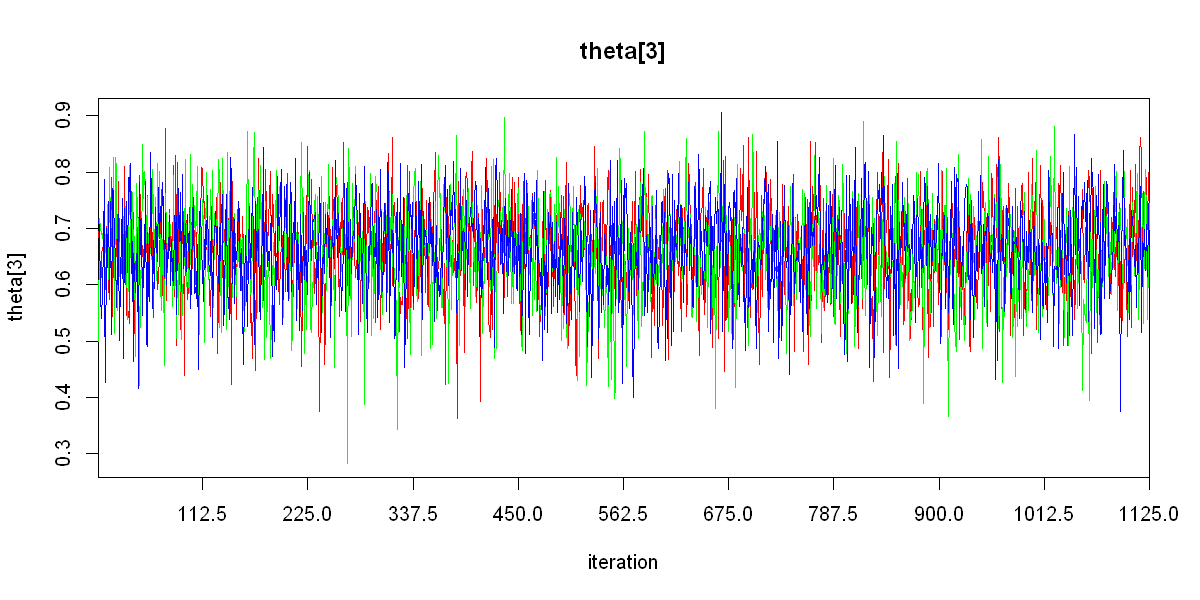

In [14]:
options(repr.plot.width=10,repr.plot.height=5)
traceplot(Mix.2.3.m1)

The following density plot shows an estimation of the posterior $\theta$ distribution from the sample generated by JAGS.

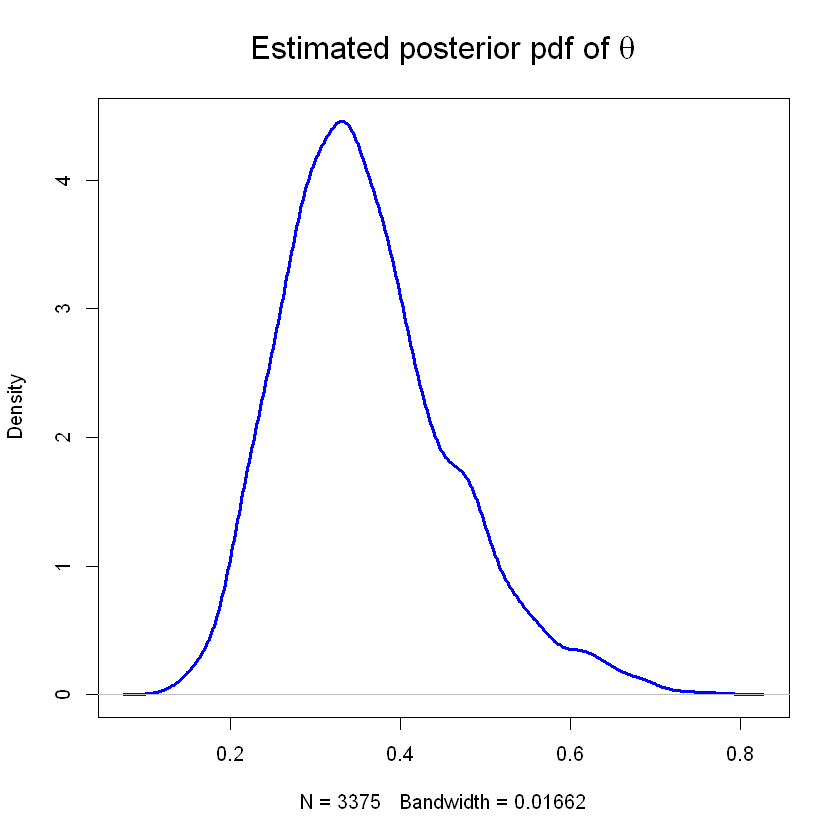

In [15]:
# Generate the sample
p.sample<-Mix.2.3.m1$BUGSoutput$sims.list$p

# Do the density plot
p.sample.density<-density(p.sample)
options(repr.plot.width=7,repr.plot.height=7)
plot(p.sample.density,lwd=2.5,col="blue",main=expression(paste("Estimated posterior pdf of ", theta)),cex.main=1.6)

Now let's compute the posterior expectation and variance.

In [16]:
Post.Expectation<-mean(p.sample)
Post.Variance<-var(p.sample)

cat(sprintf("\nPosterior expectation = %6.3f.", round(Post.Expectation,4)))
cat(sprintf("\nPosterior variance    = %6.3f.", round(Post.Variance,4)))


Posterior expectation =  0.360.
Posterior variance    =  0.010.

Finally, let's compute the Maximum A Posteriori (MAP) estimate of  𝜃 .

In [17]:
Theta.MAP<-p.sample.density$x[which.max(p.sample.density$y)]
cat(sprintf("\nMAP estimate = %6.3f", round(Theta.MAP,4)))


MAP estimate =  0.331

<h2 style="color:blue">4. Stan version</h2> 

<h2 style="color:blue">Bibliography</h2> 

http://www.scielo.org.co/pdf/rce/v36n2/v36n2a09.pdf

https://news.stanford.edu/pr/2004/diaconis-69.html

"Dynamical Bias in the Coin Toss"

https://chrispiech.github.io/probabilityForComputerScientists/en/part4/beta/